# Overview
- nb007までは取り除いていた*Name*、*Ticket*、*Cabin*を特徴量として取り扱えるよう、データ処理を行う。
- *Age*は*Sex*と*Pclass*のグループごとに中央値で補完。*Embarked*は最頻値で補完。*Cabin*は先頭のアルファベットを抽出し、欠損値はZで補完。
- *Name*からTitleを取り出し、Master、Miss、Mr、Mrs、Othersに分類。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/train.csv')   # Google Colabの場合はこちら
df_train = pd.read_csv('../data/train.csv')   # ローカルの場合はこちら
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# 特徴量をX,ラベルをyとして分離する
df_train_X = df_train.drop(['Survived'], axis=1)
df_train_y = df_train['Survived']
print(df_train_X.isnull().sum(), '\n')
print('Nan in y: %d' % df_train_y.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64 

Nan in y: 0


### 欠損値処理

In [4]:
# 'Embarked'の欠損値処理
# =======================

print('Before: \n%s\n' % df_train_X['Embarked'].value_counts())

# 欠損値は2つだけなので、最頻値('S')で埋めることとする
df_train_X['Embarked'] = df_train_X['Embarked'].fillna(df_train_X['Embarked'].mode().iloc[0])

print('After: \n%s\n' % df_train_X['Embarked'].value_counts())
print(df_train_X.isnull().sum())

Before: 
S    644
C    168
Q     77
Name: Embarked, dtype: int64

After: 
S    646
C    168
Q     77
Name: Embarked, dtype: int64

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64


In [5]:
# 'Age'の欠損値処理
# ==================

print(df_train.corrwith(df_train['Age']), '\n')

# 'Age'は'Pclass'と相関が高いため、'Pclass'と'Sex'でグループ分けし、各グループの中央値で置き換える
print(df_train_X.groupby(['Pclass', 'Sex'])['Age'].median(), '\n')
df_train_X['Age'] = df_train_X.groupby(['Pclass', 'Sex'])['Age'].apply(lambda x: x.fillna(x.median()))
print(df_train_X.isnull().sum())

PassengerId    0.036847
Survived      -0.077221
Pclass        -0.369226
Age            1.000000
SibSp         -0.308247
Parch         -0.189119
Fare           0.096067
dtype: float64 

Pclass  Sex   
1       female    35.0
        male      40.0
2       female    28.0
        male      30.0
3       female    21.5
        male      25.0
Name: Age, dtype: float64 

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64


In [6]:
# 'Cabin'の欠損値処理
# ====================

df_train_X['Cabin'].unique()

# 一文字目を取り出して新たな列'Deck'を作成、欠損値はZで置き換え
df_train_X['Deck'] = df_train_X['Cabin'].apply(lambda d: d[0] if pd.notnull(d) else 'Z')
df_train_X['Deck'].unique()
print(df_train_X.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
Deck             0
dtype: int64


### 特徴量生成

In [7]:
# 'Name'の特徴量生成
# ===================

# 'Mr'などのタイトルを抜き出して新たな列'Title'を作成
df_train_X['Title'] = df_train_X['Name'].str.extract('([A-Za-z]+)\.', expand=False)
print(df_train_X.groupby(['Title'])['Name'].count(), '\n')

# 'Master'、'Miss'、'Mr'、'Mrs'に統合もしくはその他('Others')とする
df_train_X['Title'] = df_train_X['Title'].replace(['Mlle'], 'Miss')
df_train_X['Title'] = df_train_X['Title'].replace(['Countess', 'Mme', 'Lady'], 'Mrs')
df_train_X['Title'] = df_train_X['Title'].replace(['Capt', 'Col', 'Don', 'Dr', 'Jonkheer', 'Major', 'Ms', 'Rev', 'Sir'], 'Others')

print(df_train_X['Title'].unique())

Title
Capt          1
Col           2
Countess      1
Don           1
Dr            7
Jonkheer      1
Lady          1
Major         2
Master       40
Miss        182
Mlle          2
Mme           1
Mr          517
Mrs         125
Ms            1
Rev           6
Sir           1
Name: Name, dtype: int64 

['Mr' 'Mrs' 'Miss' 'Master' 'Others']


In [8]:
# 'Ticket'の特徴量生成
# =====================

# 'Ticket'の1文字目を抽出して新たな列'Ticket_first'作成
df_train_X['Ticket_first'] = df_train_X['Ticket'].apply(lambda t: str(t)[0])

# 'Ticket'の長さによる新たな列'Ticket_length'作成
df_train_X['Ticket_length'] = df_train_X['Ticket'].apply(lambda t: len(str(t)))

df_train_X.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Title,Ticket_first,Ticket_length
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Z,Mr,A,9
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,Mrs,P,8
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Z,Miss,S,16
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,Mrs,1,6
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Z,Mr,3,6


In [9]:
# 'Family_size'の作成
# ====================

# 'SibSp'+'Parch'+1を新たな列'Family_size'に出力
df_train_X['Family_size'] = df_train_X['SibSp'] + df_train['Parch'] + 1

df_train_X.groupby(['Family_size'])['PassengerId'].count()

Family_size
1     537
2     161
3     102
4      29
5      15
6      22
7      12
8       6
11      7
Name: PassengerId, dtype: int64

### 特徴量整理

In [10]:
# 'Sex'、'Embarked'、'Deck'、'Title'、'Ticket_first'をone-hot-encodeする
df_train_X_oh = pd.get_dummies(df_train_X[['Sex', 'Embarked', 'Deck', 'Title', 'Ticket_first']], drop_first=True)

# one-hot-encodeデータを結合する
df_train_X_added = pd.concat([df_train_X, df_train_X_oh], axis=1)
print(df_train_X_added.shape)

# 'Name'、'Sex'、'Ticket'、'Cabin'、'Embarked'、'Deck'、'Title'、'Ticket_first'を削除する
df_train_X_deleted = df_train_X_added.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Deck', 'Title', 'Ticket_first'], axis=1)
print(df_train_X_deleted.shape, '\n')
df_train_X_deleted.info()

# X、yとしてNumpy配列にする
X = df_train_X_deleted.values
y = df_train_y.values

(891, 46)
(891, 38) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 38 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     891 non-null    int64  
 1   Pclass          891 non-null    int64  
 2   Age             891 non-null    float64
 3   SibSp           891 non-null    int64  
 4   Parch           891 non-null    int64  
 5   Fare            891 non-null    float64
 6   Ticket_length   891 non-null    int64  
 7   Family_size     891 non-null    int64  
 8   Sex_male        891 non-null    uint8  
 9   Embarked_Q      891 non-null    uint8  
 10  Embarked_S      891 non-null    uint8  
 11  Deck_B          891 non-null    uint8  
 12  Deck_C          891 non-null    uint8  
 13  Deck_D          891 non-null    uint8  
 14  Deck_E          891 non-null    uint8  
 15  Deck_F          891 non-null    uint8  
 16  Deck_G          891 non-null    uint8  
 17  Deck_T       

### データ解析

In [11]:
# 訓練用、テスト用にデータ分割する   # 本当は最初にしたほうがいい
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)   # 訓練:テスト = 80:20

print('Label counts in y: [0 1] =', np.bincount(y))
print('Label counts in y_train: [0 1] =', np.bincount(y_train))
print('Label counts in y_test: [0 1] =', np.bincount(y_test))

Label counts in y: [0 1] = [549 342]
Label counts in y_train: [0 1] = [439 273]
Label counts in y_test: [0 1] = [110  69]


In [13]:
# Pipeline: pl_scv
# SVC / k分割交差検証 / グリッドサーチ
# =====================================

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

pl_svc = make_pipeline(StandardScaler(), SVC(C=10.0, kernel='rbf', gamma=0.01, random_state=21, max_iter=5000))   # CVの最適値入力済

from sklearn.model_selection import GridSearchCV

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
              {'svc__C': param_range, 'svc__kernel': ['poly', 'rbf', 'sigmoid'], 'svc__gamma': param_range}]
gs = GridSearchCV(estimator=pl_svc, param_grid=param_grid, scoring='accuracy', cv=10, refit=True, n_jobs=-1)
gs.fit(X_train, y_train)
print('CV best accuracy:', gs.best_score_)
print(gs.best_params_)
bestclf = gs.best_estimator_
print('Test accuracy: %f' % bestclf.score(X_test, y_test))

CV best accuracy: 0.8482394366197182
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Test accuracy: 0.832402


In [14]:
# Pipeline: pl_randf
# ランダムフォレスト / k分割交差検証 / グリッドサーチ
# ====================================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

pl_randf = make_pipeline(RandomForestClassifier(criterion='entropy', n_estimators=400, 
                                                max_depth=8, random_state=21, n_jobs=2))   # CVの最適値入力済

from sklearn.model_selection import GridSearchCV

param_estimators_range = [100, 200, 300, 400, 500]
param_depth_range = [4, 6, 8, 10]
param_grid = [{'randomforestclassifier__criterion': ['gini', 'entropy'],
               'randomforestclassifier__n_estimators': param_estimators_range,
               'randomforestclassifier__max_depth': param_depth_range}]
gs = GridSearchCV(estimator=pl_randf, param_grid=param_grid, scoring='accuracy', cv=10, refit=True, n_jobs=-1)
gs.fit(X_train, y_train)
print('CV best accuracy:', gs.best_score_)
print(gs.best_params_)
bestclf = gs.best_estimator_
print('Test accuracy: %f' % bestclf.score(X_test, y_test))

CV best accuracy: 0.8413145539906102
{'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 400}
Test accuracy: 0.810056


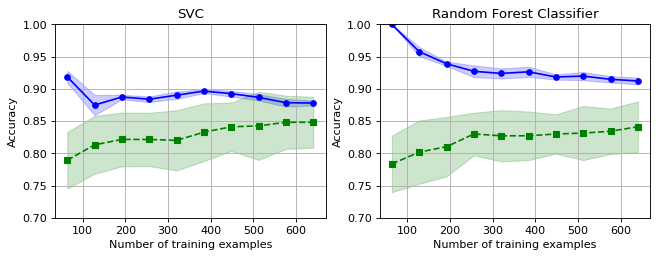

In [22]:
# Learning Curve
# ===============

from sklearn.model_selection import learning_curve

fig = plt.figure(figsize=(9.6, 3.2), dpi=80)

# SVCのプロット
svc_train_sizes, svc_train_scores, svc_valid_scores = learning_curve(estimator=pl_svc, X=X_train, y=y_train,
                                                       train_sizes=np.linspace(0.1, 1, 10), cv=10, n_jobs=-1)
svc_train_mean = np.mean(svc_train_scores, axis=1)
svc_train_std = np.std(svc_train_scores, axis=1)
svc_valid_mean = np.mean(svc_valid_scores, axis=1)
svc_valid_std = np.std(svc_valid_scores, axis=1)

ax1 = fig.add_subplot(1, 2, 1)
plt.plot(svc_train_sizes, svc_train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(svc_train_sizes, svc_train_mean+svc_train_std, svc_train_mean-svc_train_std, color='blue', alpha=0.2)
plt.plot(svc_train_sizes, svc_valid_mean, color='green', marker='s', markersize=5, linestyle='--', label='Validation accuracy')
plt.fill_between(svc_train_sizes, svc_valid_mean+svc_valid_std, svc_valid_mean-svc_valid_std, color='green', alpha=0.2)
plt.grid()
plt.title('SVC')
plt.ylim(0.7, 1.0)
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend()

# ランダムフォレストのプロット
randf_train_sizes, randf_train_scores, randf_valid_scores = learning_curve(estimator=pl_randf, X=X_train, y=y_train,
                                                       train_sizes=np.linspace(0.1, 1, 10), cv=10, n_jobs=-1)
randf_train_mean = np.mean(randf_train_scores, axis=1)
randf_train_std = np.std(randf_train_scores, axis=1)
randf_valid_mean = np.mean(randf_valid_scores, axis=1)
randf_valid_std = np.std(randf_valid_scores, axis=1)

ax2 = fig.add_subplot(1, 2, 2)
plt.plot(randf_train_sizes, randf_train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(randf_train_sizes, randf_train_mean+randf_train_std, randf_train_mean-randf_train_std, color='blue', alpha=0.2)
plt.plot(randf_train_sizes, randf_valid_mean, color='green', marker='s', markersize=5, linestyle='--', label='Validation accuracy')
plt.fill_between(randf_train_sizes, randf_valid_mean+randf_valid_std, randf_valid_mean-randf_valid_std, color='green', alpha=0.2)
plt.grid()
plt.title('Random Forest Classifier')
plt.ylim(0.7, 1.0)
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend()

# プロット画像保存
plt.savefig('../image/nb008_learningcurve.png')